In [182]:
#@title Copyright 2023 Google LLC. { display-mode: "form" }
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="ee-notebook-buttons" align="left"><td>
<a target="_blank"  href="http://colab.research.google.com/github/google/earthengine-community/blob/master/guides/linked/Earth_Engine_training_patches_computePixels.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run in Google Colab</a>
</td><td>
<a target="_blank"  href="https://github.com/google/earthengine-community/blob/master/guides/linked/Earth_Engine_training_patches_computePixels.ipynb"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a></td></table>

# Download training patches from Earth Engine

This demonstration shows how to get patches of imagery from Earth Engine for training ML models.  Specifically, use `computePixels` calls in parallel to quickly and efficiently write a TFRecord file.

## Imports

In [183]:
from google.colab import auth
from google.api_core import retry
from IPython.display import Image
from matplotlib import pyplot as plt
from numpy.lib import recfunctions as rfn

import concurrent
import ee
import google
import io
import multiprocessing
import numpy as np
import requests
import tensorflow as tf

## Authentication and initialization

Use the Colab auth widget to get credentials, then use them to initialize Earth Engine.  During initialization, be sure to specify a project and Earth Engine's [high-volume endpoint](https://developers.google.com/earth-engine/cloud/highvolume), in order to make automated requests.

In [184]:
# REPLACE WITH YOUR PROJECT!
PROJECT = 'master-thesis-ilg'

In [185]:
auth.authenticate_user()

In [186]:
credentials, _ = google.auth.default()
ee.Initialize(credentials, project=PROJECT, opt_url='https://earthengine-highvolume.googleapis.com')

## Define variables

In [187]:
# Output resolution in meters.
SCALE = 10

# Pre-compute a geographic coordinate system.
proj = ee.Projection('EPSG:4326').atScale(SCALE).getInfo()

# Get scales in degrees out of the transsform.
SCALE_X = proj['transform'][0]
SCALE_Y = -proj['transform'][4]

print("Scale X is: ", SCALE_X)
print("Scale Y is: ", SCALE_Y)



Scale X is:  8.983152841195215e-05
Scale Y is:  -8.983152841195215e-05


In [228]:
# Patch size in pixels.
PATCH_SIZE = 224

# Number of samples per ROI, and per TFRecord file.
N = 128

# Offset to the upper left corner.
OFFSET_X = -SCALE_X * PATCH_SIZE / 2
OFFSET_Y = -SCALE_Y * PATCH_SIZE / 2

# Request template.
REQUEST = {
      'fileFormat': 'NPY',
      'grid': {
          'dimensions': {
              'width': PATCH_SIZE,
              'height': PATCH_SIZE
          },
          'affineTransform': {
              'scaleX': SCALE_X,
              'shearX': 0,
              'shearY': 0,
              'scaleY': SCALE_Y,
          },
          'crsCode': proj['crs']
      }
  }

# Blue, green, red, NIR, AOT.
FEATURES_S2 = ['B2_median', 'B3_median', 'B4_median', 'B8_median', 'AOT_median']
FEATURES_VIIRS = ['avg_rad']

# TEST_ROI = ee.Geometry.Rectangle(
#     [-123.05832753906247, 37.03109527141115,
#      -121.14121328124997, 38.24468432993584])
TEST_ROI = ee.Geometry.Rectangle(
    [36.0, -2.0,
     37.0, -1.0])
# 240 VIIRS images / degree
# 1x1 degree is 57600 viirs patches
# 128 pixels x 10m is 1.280km per patch or about 3 viirs images
# therefore, about 6400 patches per square degree
# let's sample 1 in 10 of them > 640 samples

# 1 degree by 1 degree at the equator
# 111.1km x 111.1km
# 12347.6544 km2

# actually, let's use a patch size of 224, just like ResNet expects
# then I can compare ResNet with VanillaCNN
# patch size = 2.44km x 2.44km
# 50176 pixels of sentinel
# 23.406 pixels of viirs

# about 49.58 patches on each side of 1x1 degree
# that makes for 2459 patches each thing
# let's sample 1 in 10 > 256 samples


# TEST_COORDS = [-121.4351, 37.7801]
TEST_COORDS = [36.82231, -1.29213]

TEST_DATE = ee.Date('2023-09-01')

# Specify the size and shape of patches expected by the model.
KERNEL_SHAPE = [PATCH_SIZE, PATCH_SIZE]
COLUMNS_S2 = [
  tf.io.FixedLenFeature(shape=KERNEL_SHAPE, dtype=tf.float32) for k in FEATURES_S2
]
COLUMNS_VIIRS = [
  tf.io.FixedLenFeature(shape=KERNEL_SHAPE, dtype=tf.float32) for k in FEATURES_VIIRS
]
FEATURES_DICT_S2 = dict(zip(FEATURES_S2, COLUMNS_S2))
FEATURES_DICT_VIIRS = dict(zip(FEATURES_VIIRS, COLUMNS_VIIRS))

## Image retrieval functions

This section includes functions to compute a Sentinel-2 median composite and get a pacth of pixels from the composite, centered on the provided coordinates, as either a numpy array or a JPEG thumbnail (for visualization).  The functions that request patches are retriable and you can do that automatically by decorating the functions with [Retry](https://googleapis.dev/python/google-api-core/latest/retry.html).

In [189]:
def get_viirs_composite(roi,date):
  """Get a one-year VIIRS DNB median composite in the ROI."""
  start = date.advance(-1, 'year')
  end = date

  dataset = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG")
  nighttime = dataset.select('avg_rad');
  nighttime = nighttime.filterBounds(roi).filterDate(start, end)

  return nighttime.median()

def get_s2_composite(roi, date):
  """Get a one-year Sentinel-2 median composite in the ROI."""
  start = date.advance(-1, 'year')
  end = date

  s2 = ee.ImageCollection('COPERNICUS/S2_HARMONIZED')
  s2c = ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
  s2Sr = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')

  s2c = s2c.filterBounds(roi).filterDate(start, end)
  s2Sr = s2Sr.filterDate(start, end).filterBounds(roi)

  def indexJoin(collectionA, collectionB, propertyName):
    joined = ee.ImageCollection(ee.Join.saveFirst(propertyName).apply(
        primary=collectionA,
        secondary=collectionB,
        condition=ee.Filter.equals(
            leftField='system:index',
            rightField='system:index'
        ))
    )
    return joined.map(lambda image : image.addBands(ee.Image(image.get(propertyName))))

  def maskImage(image):
    s2c = image.select('probability')
    return image.updateMask(s2c.lt(50))

  withCloudProbability = indexJoin(s2Sr, s2c, 'cloud_probability')
  masked = ee.ImageCollection(withCloudProbability.map(maskImage))
  return masked.reduce(ee.Reducer.median(), 8)


@retry.Retry()
def get_patch(coords, image):
  """Get a patch centered on the coordinates, as a numpy array."""
  request = dict(REQUEST)
  request['expression'] = image
  request['grid']['affineTransform']['translateX'] = coords[0] + OFFSET_X
  request['grid']['affineTransform']['translateY'] = coords[1] + OFFSET_Y
  return np.load(io.BytesIO(ee.data.computePixels(request)))


@retry.Retry()
def get_s2_display_image(coords, image):
  """Helper to display a patch using notebook widgets."""
  point = ee.Geometry.Point(coords)
  region = point.buffer(64 * 1000).bounds()
  url = image.getThumbURL({
      'region': region,
      'dimensions': '128x128',
      'format': 'jpg',
      'min': 0, 'max': 5000,
      'bands': ['B4_median', 'B3_median', 'B2_median']
  })

  r = requests.get(url, stream=True)
  if r.status_code != 200:
    raise google.api_core.exceptions.from_http_response(r)

  return r.content

def get_viirs_display_image(coords, image):
  """Helper to display a patch using notebook widgets."""
  point = ee.Geometry.Point(coords)
  region = point.buffer(64 * 1000).bounds()
  url = image.getThumbURL({
      'region': region,
      'dimensions': '128x128',
      'format': 'jpg',
      'min': 0, 'max': 60,
      'bands': ['avg_rad']
  })

  r = requests.get(url, stream=True)
  if r.status_code != 200:
    raise google.api_core.exceptions.from_http_response(r)

  return r.content

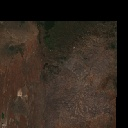

In [190]:
TEST_S2_IMAGE = get_s2_composite(TEST_ROI, TEST_DATE)
image_s2 = get_s2_display_image(TEST_COORDS, TEST_S2_IMAGE)
Image(image_s2)

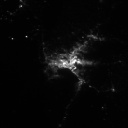

In [191]:
TEST_VIIRS_IMAGE = get_viirs_composite(TEST_ROI, TEST_DATE)
image_viirs = get_viirs_display_image(TEST_COORDS, TEST_VIIRS_IMAGE)
Image(image_viirs)

[[ 990.   945.5  739.  ... 1334.  1370.  1238. ]
 [1156.   886.   564.  ... 1504.  1534.  1294. ]
 [1089.   993.   892.  ... 1425.  1403.  1169. ]
 ...
 [1178.  1272.  1410.  ... 1188.  1213.  1332. ]
 [1285.  1494.  1364.  ... 1326.  1432.  1494. ]
 [1208.  1316.  1233.  ... 1506.  1498.  1412. ]]


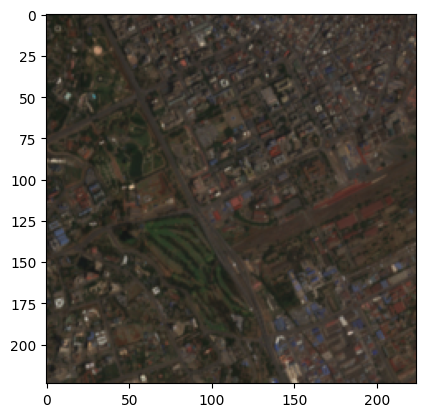

In [192]:
np_array_s2 = get_patch(TEST_COORDS, TEST_S2_IMAGE)
# This is a structured array.
print(np_array_s2['B4_median'])
display_array_s2 = rfn.structured_to_unstructured(np_array_s2[['B4_median', 'B3_median', 'B2_median']])/5000
plt.imshow(display_array_s2)
plt.show()

[[33.559998 33.559998 33.559998 ... 64.565    64.565    64.565   ]
 [33.559998 33.559998 33.559998 ... 64.565    64.565    64.565   ]
 [33.559998 33.559998 33.559998 ... 64.565    64.565    64.565   ]
 ...
 [38.699997 38.699997 38.699997 ... 29.605    29.605    29.605   ]
 [38.699997 38.699997 38.699997 ... 29.605    29.605    29.605   ]
 [37.615    37.615    37.615    ... 36.485    36.485    36.485   ]]


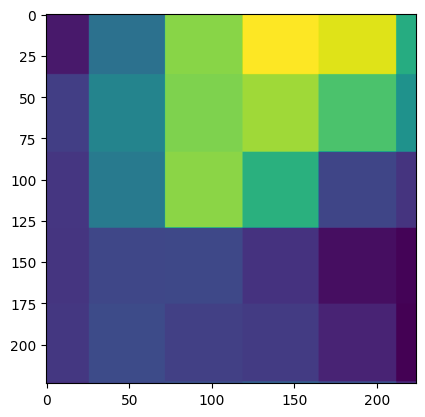

In [193]:
np_array_viirs = get_patch(TEST_COORDS, TEST_VIIRS_IMAGE)
print(np_array_viirs['avg_rad'])
display_array_viirs = rfn.structured_to_unstructured(np_array_viirs[['avg_rad']])/60
plt.imshow(display_array_viirs)
plt.show()


## Sampling functions

These are helper functions to get a random sample as a list of coordinates,  sample the composite (using `computePixels`) at each coordinate, serialize numpy arrays to `tf.Example` protos and write them into a file.  The sampling is handled in multiple threads using a `ThreadPoolExecutor`.

In [237]:
def get_sample_coords(roi, n):
  """"Get a random sample of N points in the ROI."""
  points = ee.FeatureCollection.randomPoints(region=roi, points=n, maxError=1)
  return points.aggregate_array('.geo').getInfo()


def array_to_example_s2(structured_array):
  """"Serialize a structured numpy array into a tf.Example proto."""
  feature = {}
  for f in FEATURES_S2:
    feature[f] = tf.train.Feature(
        float_list = tf.train.FloatList(
            value = structured_array[f].flatten()))
  return tf.train.Example(
      features = tf.train.Features(feature = feature))

def array_to_example_viirs(structured_array):
  """"Serialize a structured numpy array into a tf.Example proto."""
  feature = {}
  for f in FEATURES_VIIRS:
    feature[f] = tf.train.Feature(
        float_list = tf.train.FloatList(
            value = structured_array[f].flatten()))
  return tf.train.Example(
      features = tf.train.Features(feature = feature))

def write_dataset_s2(image, sample_points, file_name):
  """"Write patches at the sample points into a TFRecord file."""
  future_to_point = {
    EXECUTOR.submit(get_patch, point['coordinates'], image): point for point in sample_points
  }

  # Optionally compress files.
  writer = tf.io.TFRecordWriter(file_name)

  for future in concurrent.futures.as_completed(future_to_point):
      point = future_to_point[future]
      try:
          np_array = future.result()
          example_proto = array_to_example_s2(np_array)
          writer.write(example_proto.SerializeToString())
          writer.flush()
      except Exception as e:
          print(e)
          pass

  writer.close()

def write_dataset_viirs(image, sample_points, file_name):
  """"Write patches at the sample points into a TFRecord file."""
  future_to_point = {
    EXECUTOR.submit(get_patch, point['coordinates'], image): point for point in sample_points
  }

  # Optionally compress files.
  writer = tf.io.TFRecordWriter(file_name)

  for future in concurrent.futures.as_completed(future_to_point):
      point = future_to_point[future]
      try:
          np_array = future.result()
          example_proto = array_to_example_viirs(np_array)
          writer.write(example_proto.SerializeToString())
          writer.flush()
      except Exception as e:
          print(e)
          pass

  writer.close()

In [238]:
EXECUTOR = concurrent.futures.ThreadPoolExecutor(max_workers=N)

In [239]:
# These could come from anywhere.  Here is just a random sample.
sample_points = get_sample_coords(TEST_ROI, N)

# REPLACE WITH YOUR BUCKET!
OUTPUT_FILE_S2 = 'gs://csci5922-proj/s2test7n256.tfrecord.gz'
OUTPUT_FILE_VIIRS = 'gs://csci5922-proj/viirs7n256.tfrecord.gz'


In [240]:
# Sample patches from the image at each point.  Each sample is
# fetched in parallel using the ThreadPoolExecutor.
write_dataset_s2(TEST_S2_IMAGE, sample_points, OUTPUT_FILE_S2)

In [236]:
write_dataset_viirs(TEST_VIIRS_IMAGE, sample_points, OUTPUT_FILE_VIIRS)

## Check the written file

Load and inspect the written file by visualizing a few patches.

In [200]:
def parse_tfrecord_s2(example_proto):
  """Parse a serialized example."""
  return tf.io.parse_single_example(example_proto, FEATURES_DICT_S2)

def parse_tfrecord_viirs(example_proto):
  """Parse a serialized example."""
  return tf.io.parse_single_example(example_proto, FEATURES_DICT_VIIRS)


dataset_s2 = tf.data.TFRecordDataset(OUTPUT_FILE_S2)
dataset_s2 = dataset_s2.map(parse_tfrecord_s2, num_parallel_calls=5)

dataset_viirs = tf.data.TFRecordDataset(OUTPUT_FILE_VIIRS)
dataset_viirs = dataset_viirs.map(parse_tfrecord_viirs, num_parallel_calls=5)

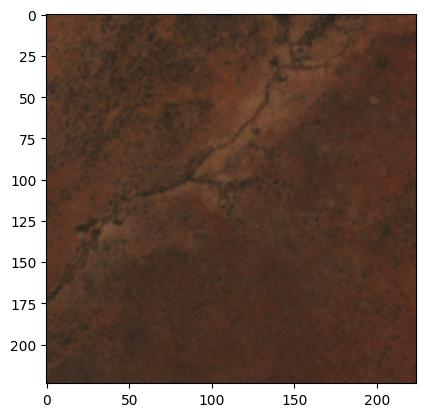

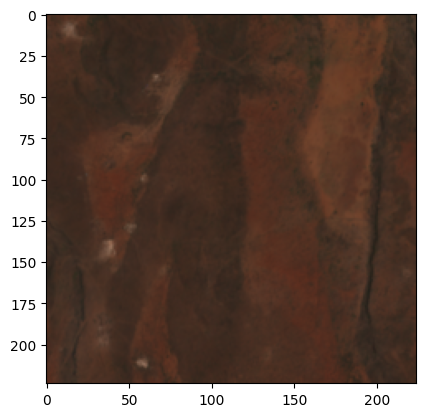

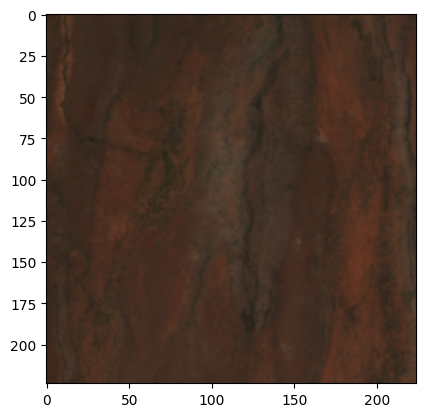

In [201]:
take_3_s2 = dataset_s2.take(3)

for data in take_3_s2:
  rgb = np.stack([
      data['B4_median'].numpy(),
      data['B3_median'].numpy(),
      data['B2_median'].numpy()], 2) / 5000
  plt.imshow(rgb)
  plt.show()


In [203]:
take_3_viirs = dataset_viirs.take(3)

for data in take_3_viirs:
  bw = data['avg_rad'].numpy() / 60
  plt.imshow(bw)
  plt.show()

## Where to go next

 - Learn about how to scale training data generation pipelines with Apache Beam in [this demo](https://github.com/GoogleCloudPlatform/python-docs-samples/tree/main/people-and-planet-ai/land-cover-classification).
 - Learn about training models on Vertex AI in [this doc](/earth-engine/guides/tf_examples#semantic-segmentation-with-an-fcnn-trained-and-hosted-on-vertex-ai).